# 🎵 Music Genre Classifier
Predicting song genres from audio features using machine learning.

**Dataset:** GTZAN-style features from 1,000 audio clips across 10 genres  
**Approach:** Compare 5 classifiers → tune the best → evaluate & visualize

## 1. Setup & Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
import joblib

plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='darkgrid', palette='muted')

RANDOM_STATE = 42
print('All libraries loaded ✓')

All libraries loaded ✓


## 2. Load & Explore Data

In [4]:
# Load dataset — update path if needed
df = pd.read_csv('Data_set/features_30_sec.csv')

print(f'Shape: {df.shape}')
print(f'Columns: {len(df.columns)}')
print(f'Missing values: {df.isnull().sum().sum()}')
df.head(3)

Shape: (1000, 60)
Columns: 60
Missing values: 0


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues


Samples per genre:
label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100


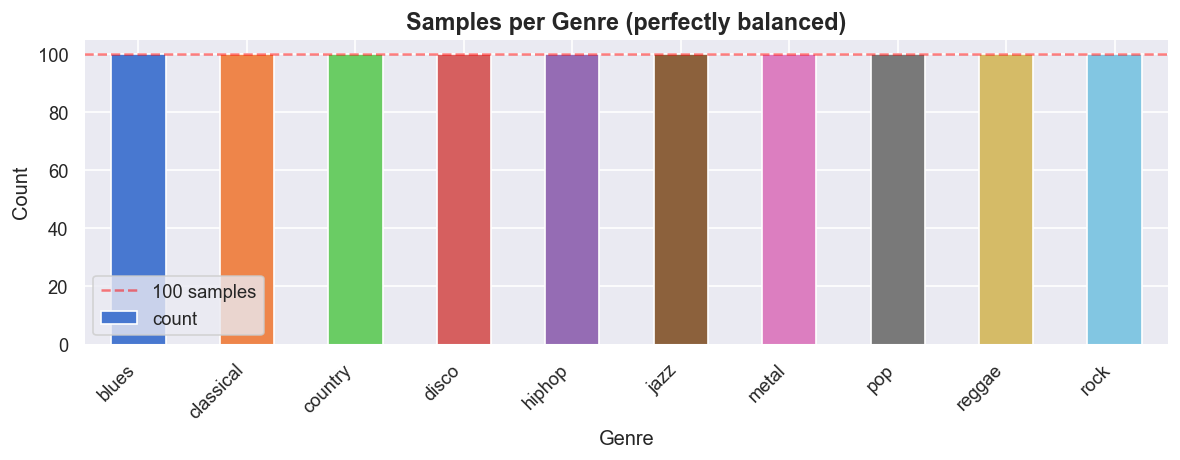

In [5]:
# Class distribution
label_counts = df['label'].value_counts()
print('Samples per genre:')
print(label_counts.to_string())

fig, ax = plt.subplots(figsize=(10, 4))
label_counts.sort_index().plot(kind='bar', ax=ax, color=sns.color_palette('muted', 10), edgecolor='white')
ax.set_title('Samples per Genre (perfectly balanced)', fontsize=14, fontweight='bold')
ax.set_xlabel('Genre')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axhline(100, color='red', linestyle='--', alpha=0.5, label='100 samples')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Data Visualization

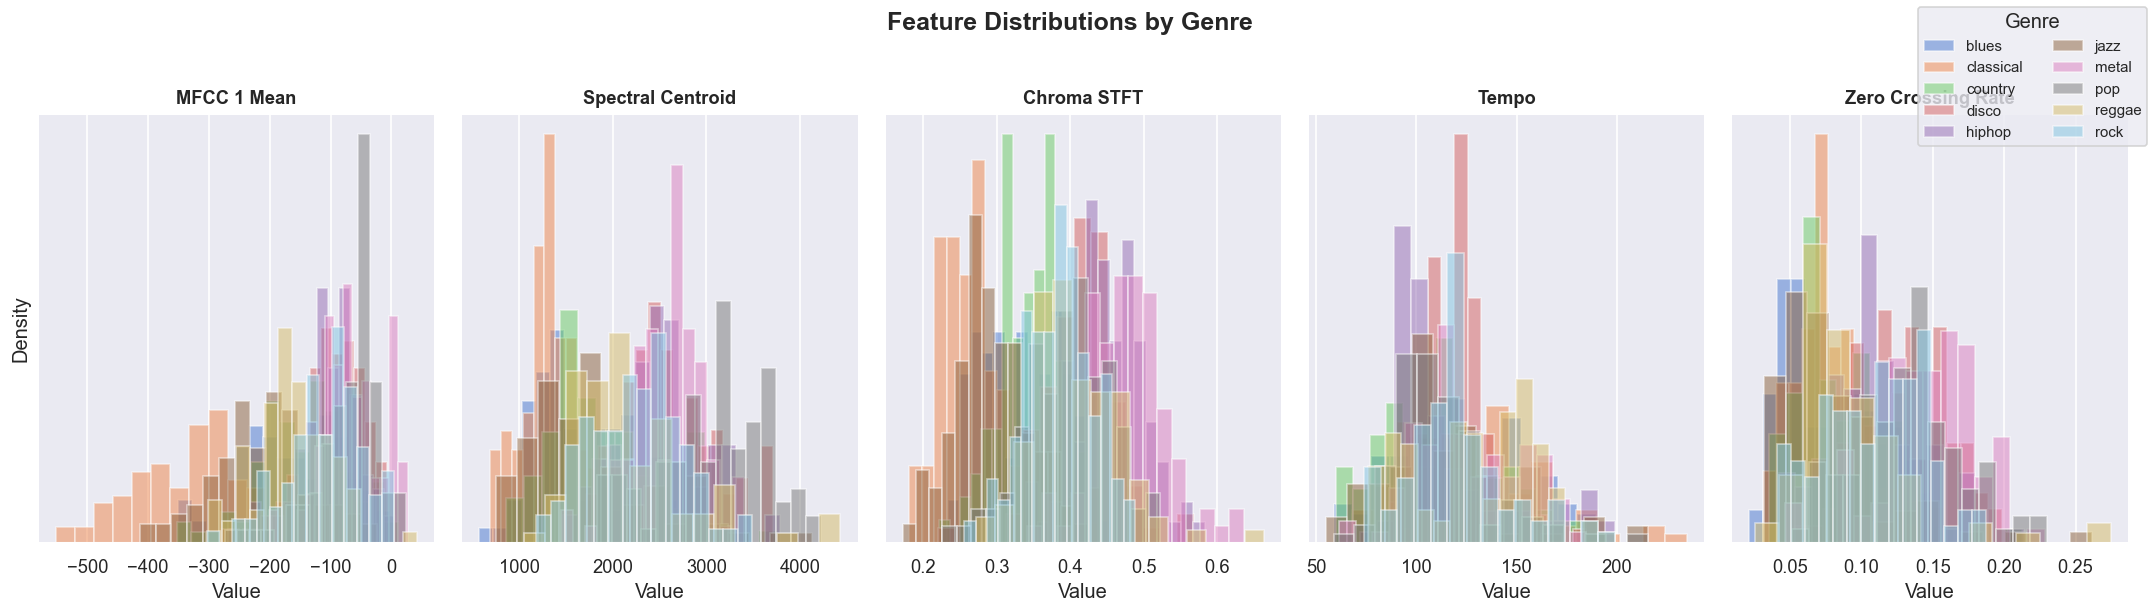

In [ ]:
# Distribution of key audio features by genre
key_features = ['mfcc1_mean', 'spectral_centroid_mean', 'chroma_stft_mean', 'tempo', 'zero_crossing_rate_mean']
feature_labels = ['MFCC 1 Mean', 'Spectral Centroid', 'Chroma STFT', 'Tempo', 'Zero Crossing Rate']

fig, axes = plt.subplots(1, len(key_features), figsize=(18, 5))
palette = sns.color_palette('muted', 10)

for ax, feat, lbl in zip(axes, key_features, feature_labels):
    for i, (genre, grp) in enumerate(df.groupby('label')):
        ax.hist(grp[feat], bins=15, alpha=0.5, color=palette[i], label=genre, density=True)
    ax.set_title(lbl, fontsize=11, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_yticks([])


axes[0].set_ylabel('Density')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2, fontsize=9, title='Genre')
fig.suptitle('Feature Distributions by Genre', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

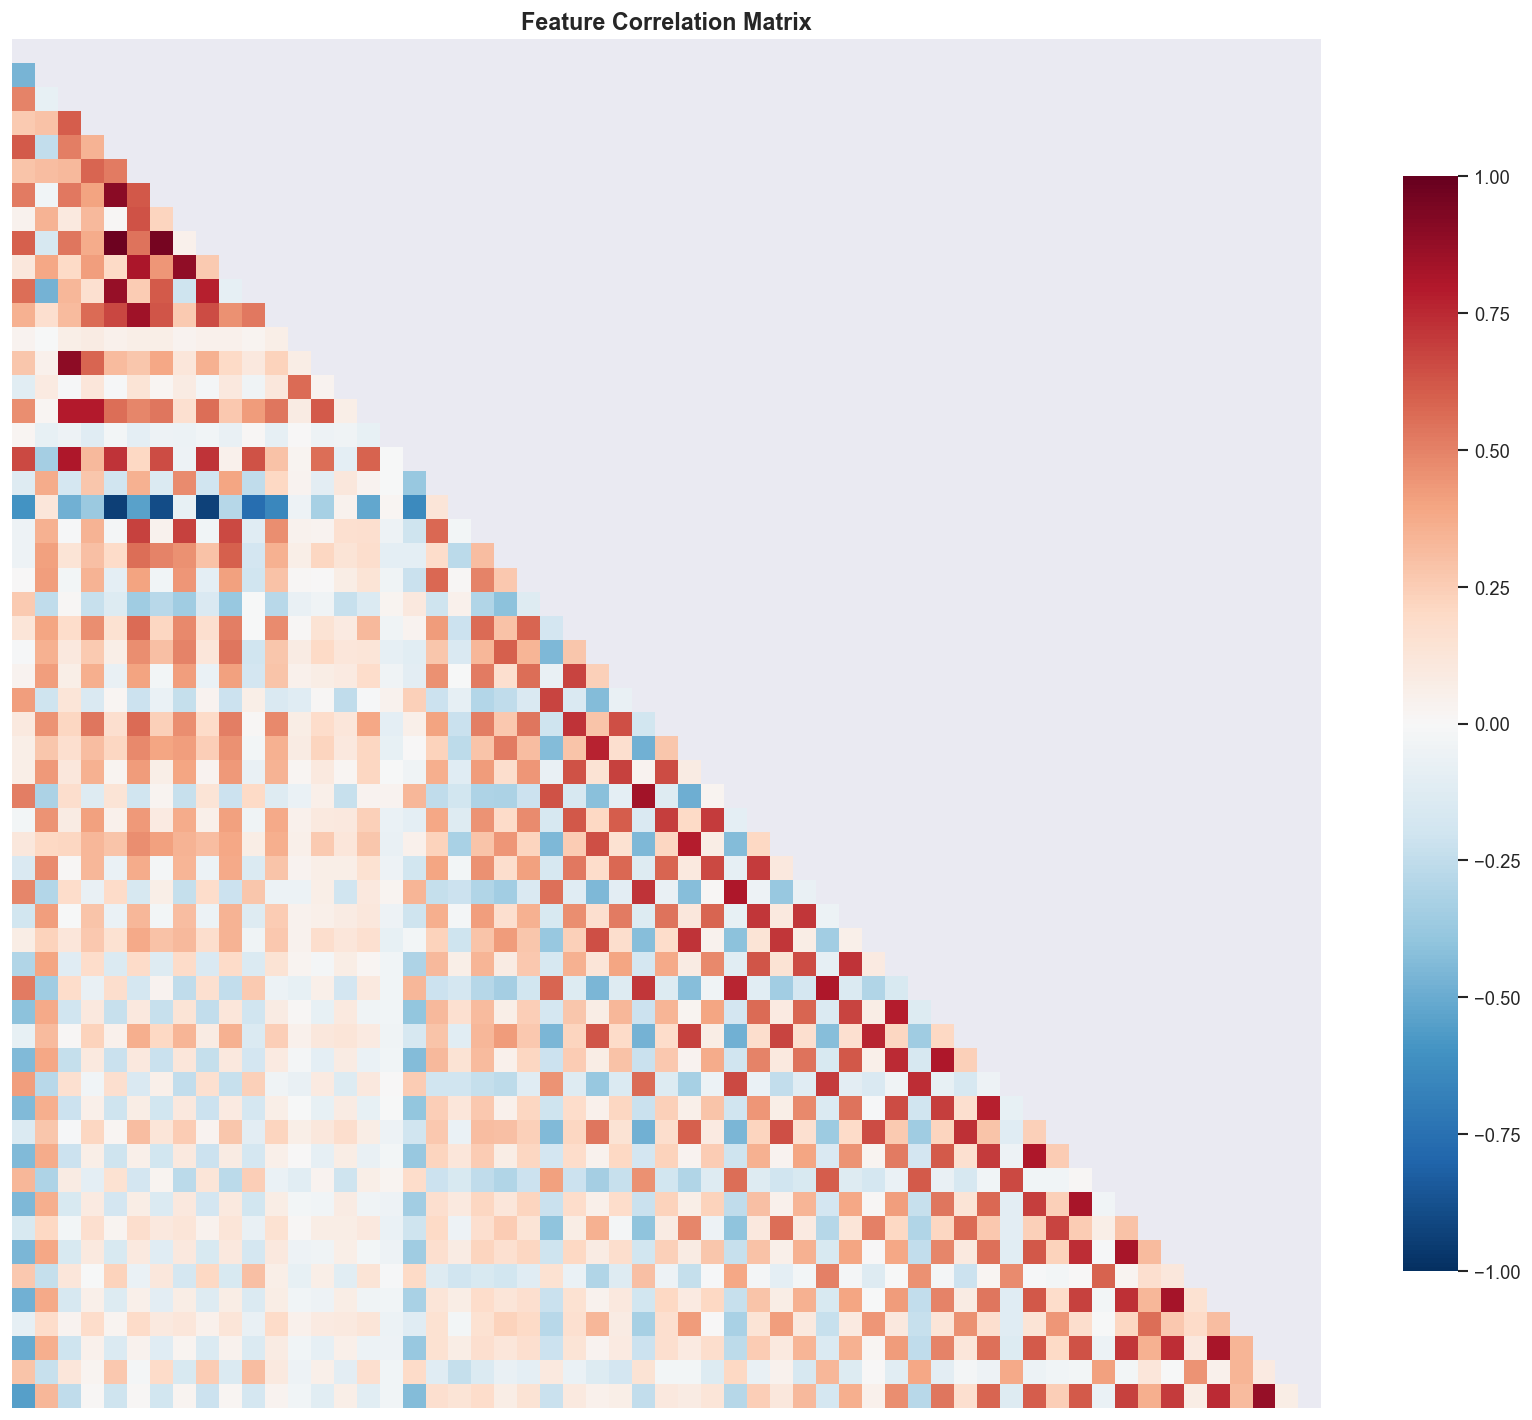

In [7]:
# Correlation heatmap of features
feature_cols = df.drop(['filename', 'label', 'length'], axis=1).columns
corr = df[feature_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, ax=ax,
            xticklabels=False, yticklabels=False,
            cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

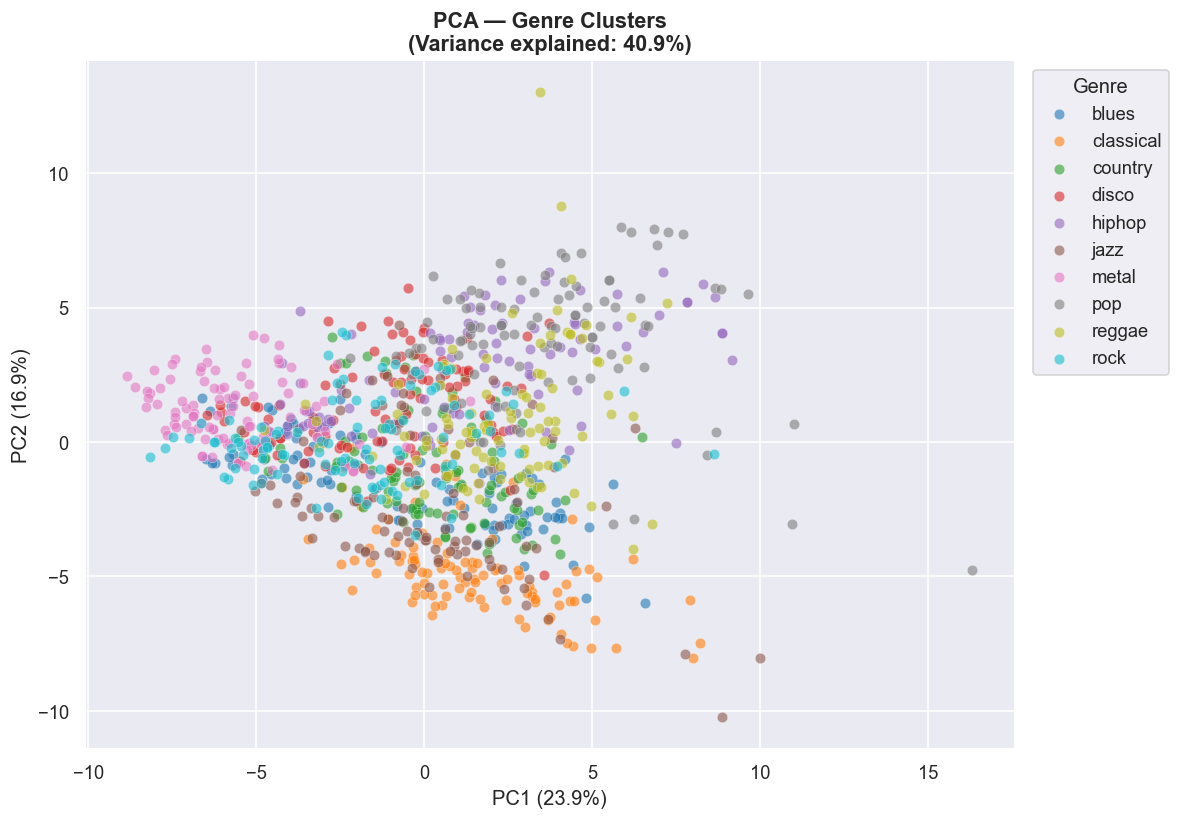

In [8]:
# PCA — 2D visualization of genre clusters
X_all = df.drop(['filename', 'label', 'length'], axis=1).values
y_all = df['label'].values

scaler_pca = StandardScaler()
X_all_s = scaler_pca.fit_transform(X_all)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_all_s)

fig, ax = plt.subplots(figsize=(10, 7))
genres = sorted(df['label'].unique())
palette = sns.color_palette('tab10', len(genres))
for i, genre in enumerate(genres):
    mask = y_all == genre
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               label=genre, color=palette[i], alpha=0.6, s=40, edgecolors='white', linewidths=0.3)

ax.set_title(f'PCA — Genre Clusters\n(Variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%)',
             fontsize=13, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.legend(title='Genre', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4. Preprocessing

In [9]:
X = df.drop(['filename', 'label', 'length'], axis=1)
y = df['label']

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Genres:', le.classes_.tolist())

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_enc
)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
print('Scaling done ✓')

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Train: (800, 57), Test: (200, 57)
Scaling done ✓


## 5. Train & Compare Multiple Models

In [10]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest':       RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'SVM (RBF)':           SVC(kernel='rbf', C=10, random_state=RANDOM_STATE),
    'KNN':                 KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting':   GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE),
}

results = {}
for name, model in models.items():
    model.fit(X_train_s, y_train)
    test_acc = accuracy_score(y_test, model.predict(X_test_s))
    cv_scores = cross_val_score(model, X_train_s, y_train, cv=5, scoring='accuracy')
    results[name] = {
        'test_acc': round(test_acc * 100, 2),
        'cv_mean':  round(cv_scores.mean() * 100, 2),
        'cv_std':   round(cv_scores.std() * 100, 2),
    }
    print(f"{name:<22} | Test: {test_acc*100:5.1f}%  | CV: {cv_scores.mean()*100:.1f}% ± {cv_scores.std()*100:.1f}%")

print('\nAll models trained ✓')

Logistic Regression    | Test:  71.0%  | CV: 70.5% ± 3.6%
Random Forest          | Test:  69.0%  | CV: 69.5% ± 5.3%
SVM (RBF)              | Test:  76.5%  | CV: 73.8% ± 3.6%


  File "c:\Users\admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\admin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\admin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\admin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


KNN                    | Test:  67.0%  | CV: 66.2% ± 4.3%
Gradient Boosting      | Test:  69.5%  | CV: 68.6% ± 1.6%

All models trained ✓


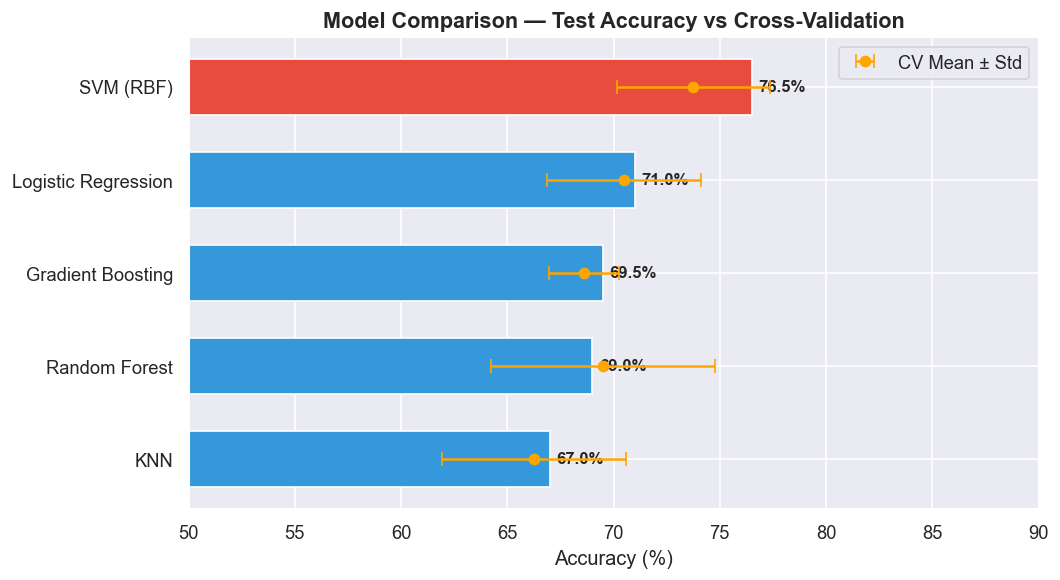


🏆 Best model: SVM (RBF) (76.5% test accuracy)


In [11]:
# Model comparison chart
res_df = pd.DataFrame(results).T.sort_values('test_acc', ascending=True)

fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#e74c3c' if i == len(res_df)-1 else '#3498db' for i in range(len(res_df))]
bars = ax.barh(res_df.index, res_df['test_acc'], color=colors, edgecolor='white', height=0.6)
ax.errorbar(res_df['cv_mean'], res_df.index,
            xerr=res_df['cv_std'], fmt='o', color='orange',
            capsize=4, label='CV Mean ± Std', zorder=5)

for bar, val in zip(bars, res_df['test_acc']):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', va='center', fontweight='bold', fontsize=10)

ax.set_xlabel('Accuracy (%)')
ax.set_title('Model Comparison — Test Accuracy vs Cross-Validation', fontsize=13, fontweight='bold')
ax.set_xlim(50, 90)
ax.legend()
plt.tight_layout()
plt.show()

best_name = res_df['test_acc'].idxmax()
print(f'\n🏆 Best model: {best_name} ({res_df.loc[best_name, "test_acc"]}% test accuracy)')

## 6. Hyperparameter Tuning (Best Model)

In [12]:
# Grid search on SVM (best performer)
# If your best model is different, adjust param_grid accordingly
param_grid = {
    'C':     [1, 5, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf', 'poly'],
}

print('Running GridSearchCV (this may take ~2 minutes)...')
grid_search = GridSearchCV(
    SVC(random_state=RANDOM_STATE),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_s, y_train)

print(f'\nBest params: {grid_search.best_params_}')
print(f'Best CV accuracy: {grid_search.best_score_*100:.2f}%')

Running GridSearchCV (this may take ~2 minutes)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best params: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 74.25%


In [13]:
# Evaluate tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_s)
tuned_acc = accuracy_score(y_test, y_pred)

print(f'Tuned SVM Test Accuracy: {tuned_acc*100:.2f}%')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=le.classes_))

Tuned SVM Test Accuracy: 76.50%

Classification Report:
              precision    recall  f1-score   support

       blues       0.77      0.85      0.81        20
   classical       0.90      0.90      0.90        20
     country       0.85      0.85      0.85        20
       disco       0.71      0.60      0.65        20
      hiphop       0.76      0.80      0.78        20
        jazz       0.71      0.85      0.77        20
       metal       1.00      0.75      0.86        20
         pop       0.78      0.70      0.74        20
      reggae       0.61      0.70      0.65        20
        rock       0.65      0.65      0.65        20

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200



## 7. Evaluation & Visualization

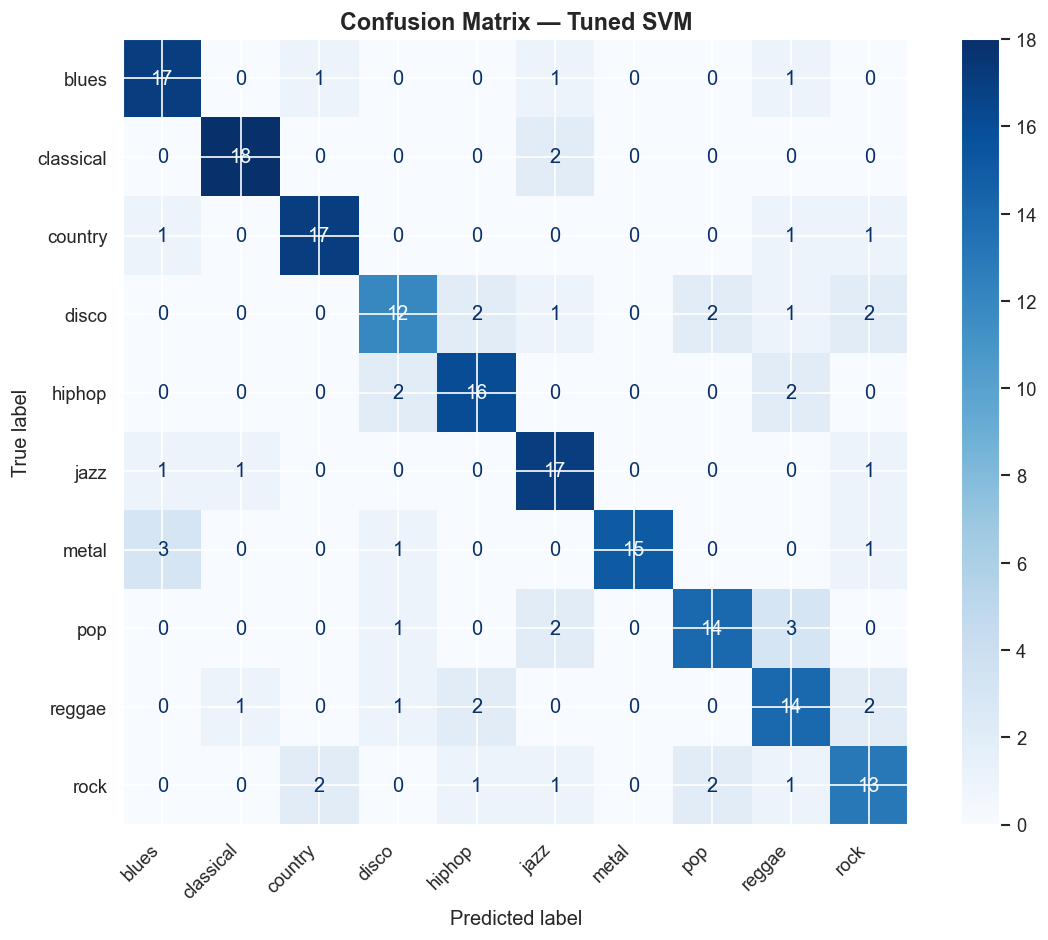


Most confused genre pairs (true → predicted):
  metal → blues: 3 misclassifications
  pop → reggae: 3 misclassifications
  rock → country: 2 misclassifications
  disco → rock: 2 misclassifications
  pop → jazz: 2 misclassifications


In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, colorbar=True, cmap='Blues')
ax.set_title('Confusion Matrix — Tuned SVM', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identify commonly confused pairs
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
np.fill_diagonal(cm_df.values, 0)
confused = cm_df.stack().sort_values(ascending=False).head(5)
print('\nMost confused genre pairs (true → predicted):')
for (true_g, pred_g), count in confused.items():
    print(f'  {true_g} → {pred_g}: {count} misclassifications')

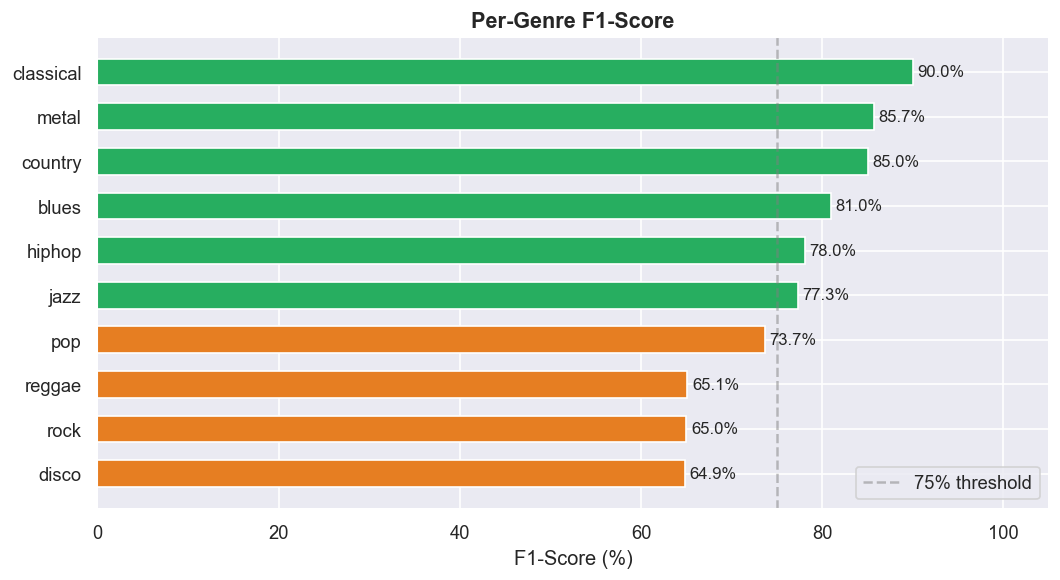

In [15]:
# Per-genre F1-score bar chart
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
f1_scores = {g: report[g]['f1-score'] for g in le.classes_}
f1_df = pd.Series(f1_scores).sort_values()

fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#27ae60' if v >= 0.75 else '#e67e22' if v >= 0.60 else '#e74c3c' for v in f1_df]
bars = ax.barh(f1_df.index, f1_df.values * 100, color=colors, edgecolor='white', height=0.6)

for bar, val in zip(bars, f1_df.values):
    ax.text(val * 100 + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val*100:.1f}%', va='center', fontsize=10)

ax.axvline(75, color='gray', linestyle='--', alpha=0.5, label='75% threshold')
ax.set_xlabel('F1-Score (%)')
ax.set_title('Per-Genre F1-Score', fontsize=13, fontweight='bold')
ax.set_xlim(0, 105)
ax.legend()
plt.tight_layout()
plt.show()

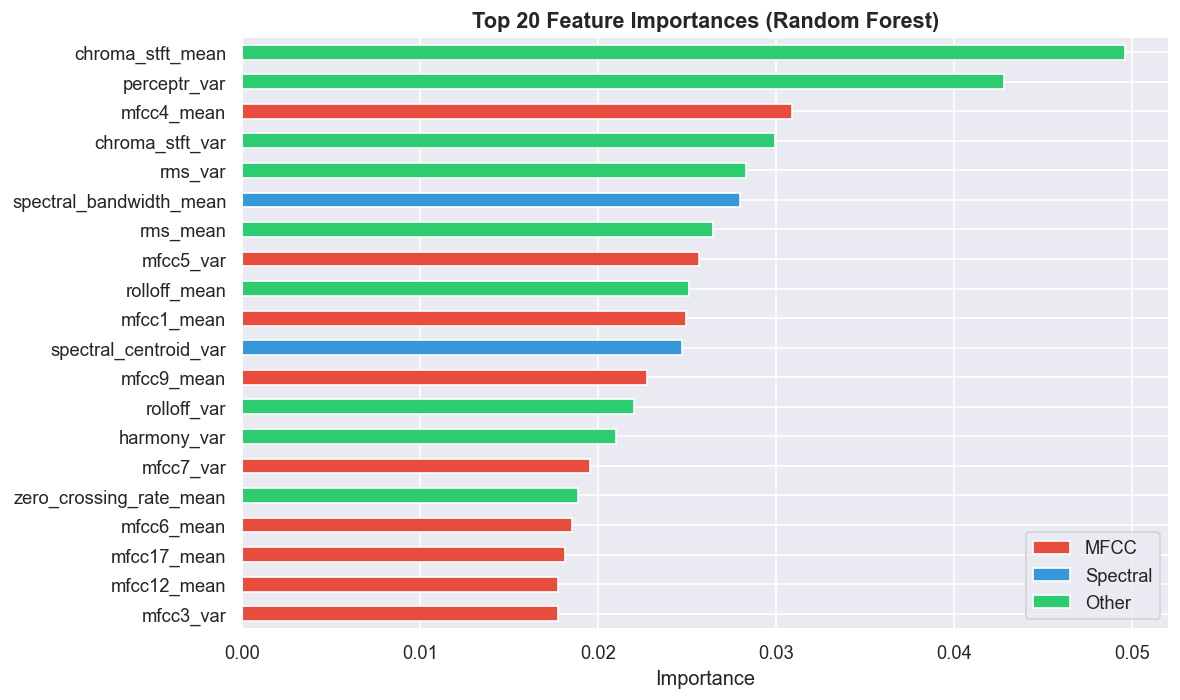

In [16]:
# Feature importance from Random Forest
rf = models['Random Forest']
feat_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if 'mfcc' in f else '#3498db' if 'spectral' in f else '#2ecc71' for f in feat_importance.index]
feat_importance[::-1].plot(kind='barh', ax=ax, color=colors[::-1], edgecolor='white')
ax.set_title('Top 20 Feature Importances (Random Forest)', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='MFCC'),
    Patch(facecolor='#3498db', label='Spectral'),
    Patch(facecolor='#2ecc71', label='Other'),
]
ax.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

## 8. Save Model & Predict New Songs

In [17]:
# Save the best model and scaler
joblib.dump(best_model, 'genre_classifier.pkl')
joblib.dump(scaler, 'genre_scaler.pkl')
joblib.dump(le, 'genre_label_encoder.pkl')
print('Model saved: genre_classifier.pkl ✓')
print('Scaler saved: genre_scaler.pkl ✓')
print('Label encoder saved: genre_label_encoder.pkl ✓')

Model saved: genre_classifier.pkl ✓
Scaler saved: genre_scaler.pkl ✓
Label encoder saved: genre_label_encoder.pkl ✓


In [18]:
def predict_genre(features_dict):
    """
    Predict genre for a new song.
    
    Parameters
    ----------
    features_dict : dict
        A dictionary of audio feature values (same columns as training data,
        excluding 'filename', 'label', 'length').
        Can also be a single-row DataFrame.
    
    Returns
    -------
    str  — predicted genre
    dict — probability/confidence scores per genre (if model supports it)
    """
    # Load saved assets (or use in-memory if already loaded)
    try:
        clf = joblib.load('genre_classifier.pkl')
        scl = joblib.load('genre_scaler.pkl')
        enc = joblib.load('genre_label_encoder.pkl')
    except FileNotFoundError:
        clf, scl, enc = best_model, scaler, le

    X_new = pd.DataFrame([features_dict]) if isinstance(features_dict, dict) else features_dict
    X_new_s = scl.transform(X_new)
    pred_idx = clf.predict(X_new_s)[0]
    genre = enc.inverse_transform([pred_idx])[0]

    scores = None
    if hasattr(clf, 'predict_proba'):
        probs = clf.predict_proba(X_new_s)[0]
        scores = dict(zip(enc.classes_, np.round(probs * 100, 1)))
    elif hasattr(clf, 'decision_function'):
        decision = clf.decision_function(X_new_s)[0]
        exp = np.exp(decision - decision.max())
        scores = dict(zip(enc.classes_, np.round(exp / exp.sum() * 100, 1)))

    return genre, scores


# ---- Demo: predict on a test sample ----
sample_idx = 0
sample_features = X_test.iloc[[sample_idx]]
true_genre = le.inverse_transform([y_test[sample_idx]])[0]

predicted_genre, confidence = predict_genre(sample_features)
print(f'True genre:      {true_genre}')
print(f'Predicted genre: {predicted_genre}')
if confidence:
    top5 = sorted(confidence.items(), key=lambda x: -x[1])[:5]
    print('\nTop-5 confidence scores:')
    for genre, conf in top5:
        bar = '█' * int(conf / 4)
        print(f'  {genre:<12} {bar} {conf:.1f}%')

True genre:      classical
Predicted genre: classical

Top-5 confidence scores:
  classical    ████████████████ 64.4%
  jazz         █████ 23.6%
  country      ██ 8.1%
  blues         2.7%
  pop           0.7%


## 9. Bonus: Try the 3-Second Dataset

The `features_3_sec.csv` file has **10,000 samples** (10× more data, shorter clips). More data often helps — worth comparing.

In [19]:
df3 = pd.read_csv('Data_set/features_3_sec.csv')
print(f'3-sec dataset shape: {df3.shape}')
print(f'Labels: {df3["label"].value_counts().to_dict()}')

X3 = df3.drop(['filename', 'label', 'length'], axis=1)
y3_enc = le.fit_transform(df3['label'])   # refit encoder on full label set

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y3_enc
)

scaler3 = StandardScaler()
X3_train_s = scaler3.fit_transform(X3_train)
X3_test_s  = scaler3.transform(X3_test)

svm3 = SVC(**grid_search.best_params_, random_state=RANDOM_STATE)
svm3.fit(X3_train_s, y3_train)
acc3 = accuracy_score(y3_test, svm3.predict(X3_test_s))

print(f'\nSVM on 3-sec data: {acc3*100:.2f}%')
print(f'SVM on 30-sec data: {tuned_acc*100:.2f}%')
print(f'\nDifference: {(acc3 - tuned_acc)*100:+.2f}%')

3-sec dataset shape: (9990, 60)
Labels: {'blues': 1000, 'jazz': 1000, 'metal': 1000, 'pop': 1000, 'reggae': 1000, 'disco': 999, 'classical': 998, 'hiphop': 998, 'rock': 998, 'country': 997}

SVM on 3-sec data: 90.29%
SVM on 30-sec data: 76.50%

Difference: +13.79%
